可以看到实际的数据实际上是与真实的情况有冲突的，数据的个数是少于期望的数据个数的。
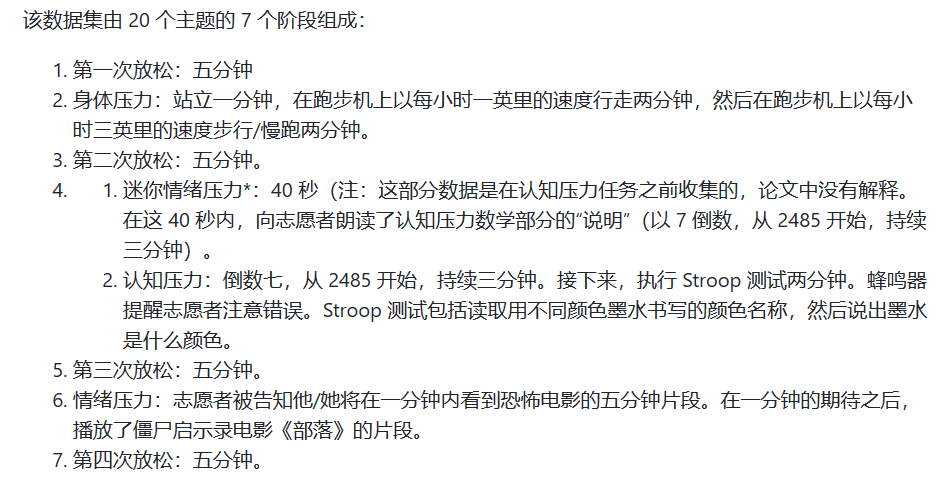


因此，不能直接通过采样频率以及时间来确定样本的标签，因此，我考虑利用实验的时间占比来划分数据的标签。
总共有四个状态

A放松状态5分钟，B身体压力5分钟，C放松状态5分钟，D情绪压力5分钟，E认知压力5分钟，F放松状态5分钟，G情绪压力5分钟，H放松状态5分钟
总时间是5+5+5+5+5+5+5+5=40 各占1/8

数据集中Relaxation类别由四个阶段的采样数据组成，其数据量远远超过其余3个类别。Relaxation类别的数据量过多会导致两个问题：1、类别之间数据量不平衡，使得模型倾向于将每条数据记录归为Relaxation类别；另一方面，由于采样过程是连续的，处于其他Relaxation阶段的实验对象可能无法真正的平静下来恢复到初始状态，我们考虑去除后面三个阶段的Relaxation类别，因此对于一个实验对象的精神状态占比变成了

A放松状态5分钟，B身体压力5分钟，C情绪压力5分,D认知压力5分钟,E情绪压力5分钟
总时间25分钟，我们把原本数据集分成8份，需要去除其中的第3,6,8的段，考虑定义放松为0，身体压力1，情绪压力2，认知压力3，
处理完后的数据可以看做总共5份

又因为我们总共有20名测试者，我们考虑直接把20个测试者的数据拼接到一块，接下来就是根据思路来处理数据

1.把每个测试者的数据分为8份，去掉其中3,6,8段

2.把每个测试者处理完后的数据进行拼接

3.把拼接完后的数据（20个实验对象），分成20份，对于每一份数据，分成5份，构建标签，第一份0，第二份1，第三份2，第四份3，第五份2，添加到数据集的最后一列作为标签或者单独分出来





# 数据预处理

In [6]:
import wfdb
import numpy as np

# 设置数据路径和记录名
data_path = 'data/non-eeg-dataset-for-assessment-of-neurological-status-1.0.0/'

def process_subject_data(subject_id):
    # 读取 AccTempEDA 数据
    record_name_AccTempEDA = f'Subject{subject_id}_AccTempEDA'
    signals_AccTempEDA, _ = wfdb.rdsamp(data_path + record_name_AccTempEDA)
    # 转置数据
    transposed_data = np.transpose(signals_AccTempEDA)
    # 分割数据为8份并去除指定部分
    num_features, num_samples = transposed_data.shape
    num_segments = 8

    # 创建一个存储分割后数据的列表
    segments = []

    for i in range(num_segments):
        start_idx = i * (num_samples // num_segments)
        end_idx = (i + 1) * (num_samples // num_segments) if i != num_segments - 1 else None
        segment = transposed_data[:, start_idx:end_idx]
    
        if (i + 1) % 3 != 0:  # 去除第3, 6, 8份
            segments.append(segment)

    # 合并剩余的数据
    processed_data = np.concatenate(segments, axis=1)
    return processed_data

# 处理每个测试者的数据并打印形状
num_subjects = 20
processed_subjects_data = [process_subject_data(i) for i in range(1, num_subjects + 1)]

# 计算最小的段数
min_num_segments = min(processed_data.shape[1] for processed_data in processed_subjects_data)

# 裁剪每个测试者的数据以匹配最小的段数
processed_subjects_data = [data[:, :min_num_segments] for data in processed_subjects_data]

# 拼接处理后的数据并按要求重新组合
final_data = np.concatenate(processed_subjects_data, axis=1)
print("final_data shape:", final_data.shape)


final_data shape: (5, 272660)


In [7]:
 # 输出一部分数据检查情况
# final_data[:,:1]

In [8]:
def process_subject_data_spo2(subject_id):
    # 读取 SPO2 数据
    record_name_spo2 = f'Subject{subject_id}_SpO2HR'
    signals_spo2, _ = wfdb.rdsamp(data_path + record_name_spo2)
    # 转置数据
    transposed_data = np.transpose(signals_spo2)
    # 分割数据为8份并去除指定部分
    num_features, num_samples = transposed_data.shape
    num_segments = 8

    # 创建一个存储分割后数据的列表
    segments = []

    for i in range(num_segments):
        start_idx = i * (num_samples // num_segments)
        end_idx = (i + 1) * (num_samples // num_segments) if i != num_segments - 1 else None
        segment = transposed_data[:, start_idx:end_idx]
    
        if (i + 1) % 3 != 0:  # 去除第3, 6, 8份
            segments.append(segment)

    # 合并剩余的数据
    processed_data = np.concatenate(segments, axis=1)
    return processed_data

# 处理每个测试者的数据并打印形状
num_subjects = 20
processed_subjects_data = [process_subject_data_spo2(i) for i in range(1, num_subjects + 1)]

# 计算最小的段数
min_num_segments = min(processed_data.shape[1] for processed_data in processed_subjects_data)

# 裁剪每个测试者的数据以匹配最小的段数
processed_subjects_data = [data[:, :min_num_segments] for data in processed_subjects_data]

final_data_spo2 = np.concatenate(processed_subjects_data, axis=1)
print("final_data_spo2 shape:", final_data_spo2.shape)


final_data_spo2 shape: (2, 34200)


可以看到，SpO2HR的数据量是与AccTempEDA不一样的，为了转换为网格数据使用CNN训练，显然拓展SpO2HR的样本量是不可避免的。但是，这是不成整数倍的，有没有比较合适的处理办法呢？有！我们可以考虑插值的方法，这样做的数据更加有合理性，比直接复制来得好！当然也可以考虑三次埃尔米特插值

优化点：可以利用更适合时间序列的插值方法，比如指数平均

这里考虑样条插值

In [9]:
from scipy.interpolate import InterpolatedUnivariateSpline

# 目标列数
target_columns = 272660

# 创建原始和目标索引
original_indices = np.linspace(0, 1, final_data_spo2.shape[1])
target_indices = np.linspace(0, 1, target_columns)

# 初始化插值结果数组
interpolated_data = np.zeros((final_data_spo2.shape[0], target_columns))

# 对每一行进行样条插值
for i in range(final_data_spo2.shape[0]):
    # 创建样条插值器
    interpolator = InterpolatedUnivariateSpline(original_indices, final_data_spo2[i, :])
    
    # 使用插值器获取新的值
    interpolated_data[i, :] = interpolator(target_indices)

# 验证新数据的形状
print('interpolated_data shape: ',interpolated_data.shape)



interpolated_data shape:  (2, 272660)


In [10]:
# 打印一下看一下是否符合预期
# interpolated_data

In [11]:
# 将两个数组沿第一个轴（行）拼接
combined_data = np.vstack((final_data, interpolated_data))

# 验证拼接后的数据形状
combined_data.shape

(7, 272660)

In [12]:
# 打印一下看下是否符合预期
# combined_data[:,1]

In [13]:
# 对每个特征（即每行）进行 z-score 标准化
combined_data_normalized = np.zeros_like(combined_data)
for i in range(combined_data.shape[0]):  # 遍历每行（特征）
    feature = combined_data[i, :]
    mean = np.mean(feature)
    std = np.std(feature)
    combined_data_normalized[i, :] = (feature - mean) / (std + 1e-8)  # 添加平滑项以防止除以零

print("combinded_data_normalized shape: ",combined_data_normalized.shape)



combinded_data_normalized shape:  (7, 272660)


In [14]:
# 验证标准化后数据的一小部分
# combined_data_normalized[:, :5]  # 显示前5列的标准化结果

In [15]:
# 定义参数
num_subjects = 100
total_data_length = combined_data_normalized.shape[1]  # 获取列数
cycle_length = 5

# 计算每份数据的平均长度，将多余部分分配到前几份
average_length = total_data_length // num_subjects
extra_length = total_data_length % num_subjects
data_lengths = [average_length + 1 if i < extra_length else average_length for i in range(num_subjects)]

# 创建标签序列 [0, 1, 2, 3, 2, 0, 1, 2, 3, 2, ...]，根据每份数据长度分配标签
labels_pattern = [0, 1, 2, 3, 2]
labels = []

for i in range(num_subjects):
    pattern_index = i % len(labels_pattern)
    labels.extend([labels_pattern[pattern_index]] * data_lengths[i])

labels = np.array(labels)

# 检查标签长度是否与数据长度相同
if len(labels) != total_data_length:
    raise ValueError("标签长度与数据长度不匹配")

# 将标签作为新的一行加到数据中
final_labeled_data = np.vstack((combined_data_normalized, labels))

# 输出最终数据形状和一小部分标签数据进行验证
final_labeled_data.shape



(8, 272660)

In [16]:
# 输出一小部分标签数据进行验证
# final_labeled_data[:,2725:2730]

### 时间滑窗


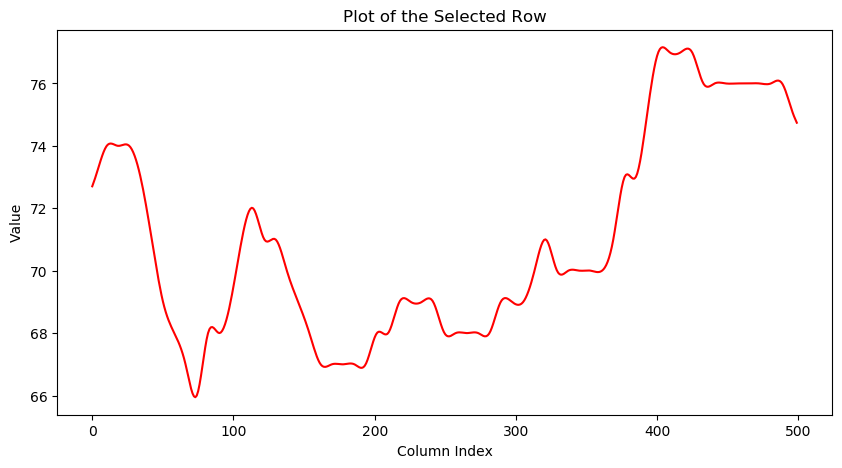

In [33]:
import matplotlib.pyplot as plt

# 假设 data 是您的 (8, 272660) 数组
# 选择第一行，索引为0
data = combined_data
row_to_plot = data[6, 500:1000]

# 绘制选中行的曲线
plt.figure(figsize=(10, 5))
plt.plot(row_to_plot,color = 'red')
plt.title('Plot of the Selected Row')
plt.xlabel('Column Index')
plt.ylabel('Value')
plt.show()


In [13]:
from collections import Counter
train_data = final_labeled_data
T = 40  # 窗口大小
step = 20  # 每次滑动的步长

# 初始化样本和标签列表
samples = []
labels = []

# 遍历数据，创建窗口样本
for start in range(0, train_data.shape[1] - T + 1, step):
    end = start + T
    sample = train_data[:-1, start:end]  # 取出特征数据
    label_window = train_data[-1, start:end]  # 取出标签数据

    # 确定窗口中最常见的标签
    most_common_label = Counter(label_window).most_common(1)[0][0]
    
    # 添加到样本和标签列表
    samples.append(sample)
    labels.append(most_common_label)

# 转换为numpy数组
samples = np.array(samples)
labels = np.array(labels)

# 打印形状以验证
samples.shape # 13632代表序列数，或者我们说图像数，7代表特征数，40代表一个特征数里边的数据。

# 现在可以那么理解，13632个图片，四分类任务，每个图片的高与宽是7与40，然后用CNN来进行分类


(13632, 7, 40)

In [14]:
# 打印验证
samples[1,:,1:3]

array([[ 0.46518646,  0.46518646],
       [-0.68957132, -0.68957132],
       [ 0.19327939,  0.19327939],
       [-1.02180198, -1.02180198],
       [-0.74654741, -0.74654741],
       [ 0.54372633,  0.5457098 ],
       [ 0.64191408,  0.64323107]])

In [15]:
# labels[:500]

独热编码（One-hot Encoding）是一种常用的处理分类标签的方法，它将每个类别转换为一个仅在对应类别位置为1，其余位置为0的二进制向量。

In [16]:
# 确保 labels 是整数类型
labels = labels.astype(int)

# 获取标签的唯一类别数
num_classes = len(np.unique(labels))

# 使用 numpy 的 eye 函数来创建独热编码矩阵
# 这次我们转置矩阵，使得每个标签的独热编码成为一列
one_hot_labels = np.eye(num_classes)[:, labels]

# 打印一部分结果以验证
one_hot_labels.shape

(4, 13632)

In [17]:
# 打印一部分结果以验证
one_hot_labels[:,:500]

array([[1., 1., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 1., 1.]])

In [18]:
final_train = samples
final_label = one_hot_labels
print("final_train shape: ",final_train.shape)
print("final_label shape: ",final_label.shape)

final_train shape:  (13632, 7, 40)
final_label shape:  (4, 13632)


## 模型搭建

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
import numpy as np

# 将标签从独热编码转换为类别索引
labels = np.argmax(final_label, axis=0)

# 转换数据为 PyTorch 张量，并增加一个通道维度
X = torch.tensor(final_train, dtype=torch.float32).unsqueeze(1)  # (13632, 1, 7, 40)
y = torch.tensor(labels, dtype=torch.long)  # (13632,)

# 创建数据加载器
dataset = TensorDataset(X, y)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)



## 网络结构可视化
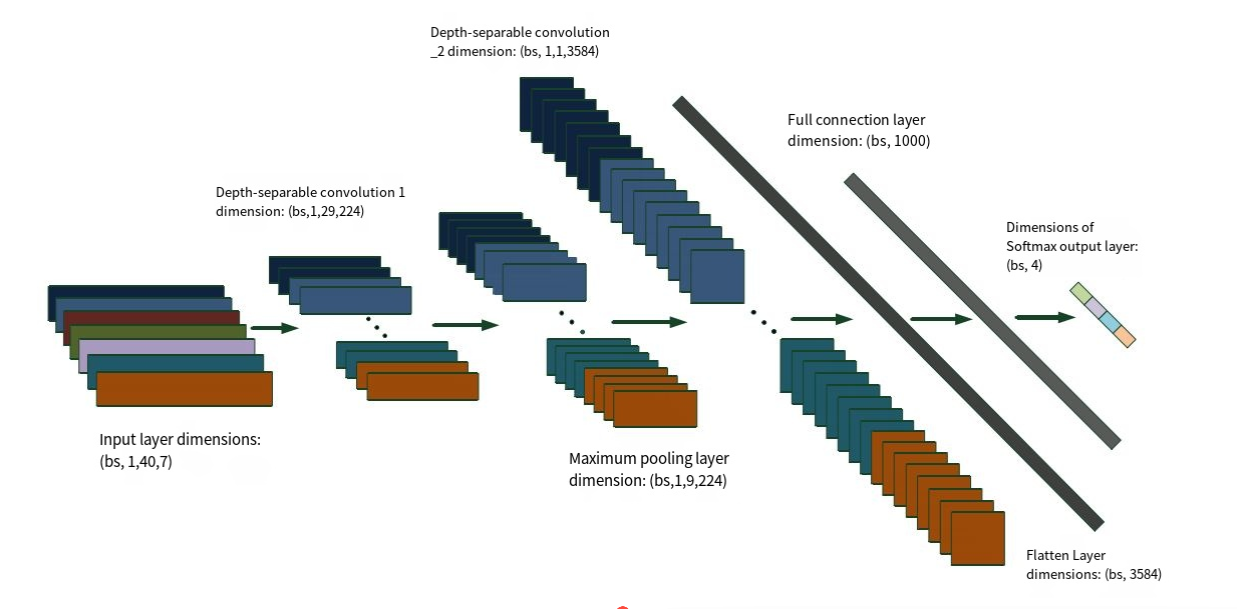

In [25]:
# 网络结构定义
# 这一部分超参数引用的论文，目的在于复现
class StressNet(nn.Module):
    def __init__(self):
        super(StressNet, self).__init__()
        # 第一个深度可分离卷积层
        self.depthwise_conv1 = nn.Conv2d(1, 32, kernel_size=(1, 12), groups=1)
        self.pointwise_conv1 = nn.Conv2d(32, 32, kernel_size=1)
        self.relu1 = nn.ReLU()
        
        # 最大池化层
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 12), stride=(1, 2))
        
        # BN_1层
        self.bn1 = nn.BatchNorm2d(32, momentum=0.99, eps=0.001)
        
        # Dropout_1层
        self.dropout1 = nn.Dropout(0.5)
        
        # 第二个深度可分离卷积层
        self.depthwise_conv2 = nn.Conv2d(32, 512, kernel_size=(1, 9), groups=32)
        self.pointwise_conv2 = nn.Conv2d(512, 512, kernel_size=1)
        self.relu2 = nn.ReLU()
        
        # BN_2层
        self.bn2 = nn.BatchNorm2d(512, momentum=0.99, eps=0.001)
        
        # Dropout_2层
        self.dropout2 = nn.Dropout(0.5)
        
        # Flatten层
        # 在forward函数中实现
        
        # 全连接层
        self.fc1 = nn.Linear(3584, 1000)
        self.tanh = nn.Tanh()
        
        # BN_3层
        self.bn3 = nn.BatchNorm1d(1000, momentum=0.99, eps=0.001)
        
        # Dropout_3层
        self.dropout3 = nn.Dropout(0.5)
        
        # 输出层
        self.fc2 = nn.Linear(1000, 4)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.relu1(self.pointwise_conv1(self.depthwise_conv1(x)))
        x = self.pool1(x)
        x = self.bn1(x)
        x = self.dropout1(x)
        
        x = self.relu2(self.pointwise_conv2(self.depthwise_conv2(x)))
        x = self.bn2(x)
        x = self.dropout2(x)
        
        x = torch.flatten(x, 1)  # Flatten层
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.bn3(x)
        x = self.dropout3(x)
        
        x = self.fc2(x)
        x = self.softmax(x)
        return x

In [26]:
# 实例化模型
model = StressNet()

# 损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005) # 原本的lr是0.001，但由于val acc一直在0.9所以考虑降低lr

# 学习率衰减
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=30, factor=0.1) 

# 用于可视化的列表
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [30]:
# 训练循环
best_val_loss = float('inf')
for epoch in range(500):
    # 训练阶段
    model.train()
    train_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)
    
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)上

    # 验证阶段
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)
    
    # 打印状态信息
    print(f'Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f} | Train Accuracy: {train_accuracies[-1]:.4f} | '
          f'Val Loss: {val_losses[-1]:.4f} | Val Accuracy: {val_accuracies[-1]:.4f}')
    
    # 学习率衰减逻辑
    scheduler.step(val_losses[-1])

    # 早期停止逻辑
    if val_losses[-1] < best_val_loss:
        best_val_loss = val_losses[-1]
        model_save_path = './best_model.pth'
        torch.save(model.state_dict(), 'best_model.pth') # # 保存最佳模型参数
    else:
        if epoch >= 50 and val_losses[-1] > best_val_loss:
            print("Early stopping due to no improvement in validation loss")
            break


Epoch 1 | Train Loss: 0.8052 | Train Accuracy: 0.9385 | Val Loss: 0.8158 | Val Accuracy: 0.9274
Epoch 2 | Train Loss: 0.8062 | Train Accuracy: 0.9371 | Val Loss: 0.8229 | Val Accuracy: 0.9193
Epoch 3 | Train Loss: 0.8050 | Train Accuracy: 0.9377 | Val Loss: 0.8061 | Val Accuracy: 0.9347
Epoch 4 | Train Loss: 0.8055 | Train Accuracy: 0.9388 | Val Loss: 0.8178 | Val Accuracy: 0.9252
Epoch 5 | Train Loss: 0.8032 | Train Accuracy: 0.9414 | Val Loss: 0.8137 | Val Accuracy: 0.9311
Epoch 6 | Train Loss: 0.8059 | Train Accuracy: 0.9372 | Val Loss: 0.8099 | Val Accuracy: 0.9318
Epoch 7 | Train Loss: 0.8076 | Train Accuracy: 0.9360 | Val Loss: 0.8112 | Val Accuracy: 0.9322
Epoch 8 | Train Loss: 0.8038 | Train Accuracy: 0.9408 | Val Loss: 0.8046 | Val Accuracy: 0.9388
Epoch 9 | Train Loss: 0.8049 | Train Accuracy: 0.9396 | Val Loss: 0.8065 | Val Accuracy: 0.9380
Epoch 10 | Train Loss: 0.8055 | Train Accuracy: 0.9391 | Val Loss: 0.8141 | Val Accuracy: 0.9281
Epoch 11 | Train Loss: 0.8042 | Train A

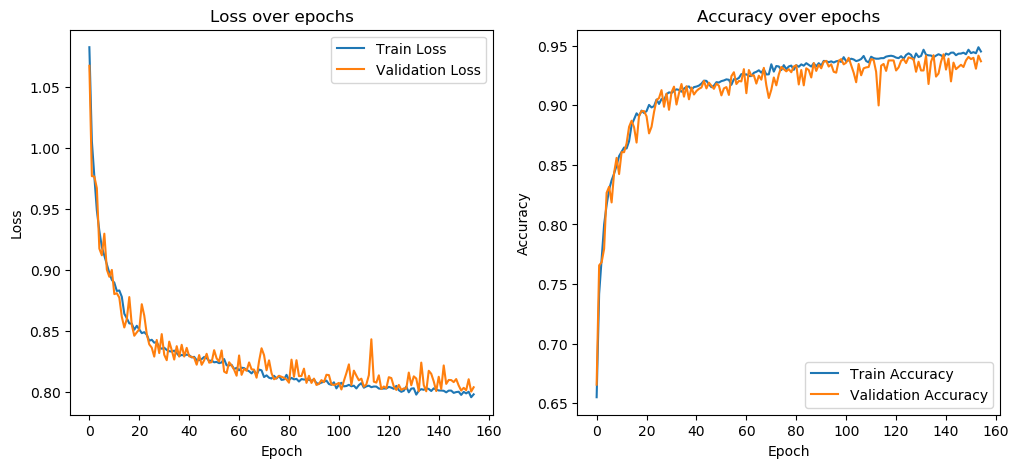

In [31]:
# 可视化训练和验证损失
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 可视化训练和验证准确率
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


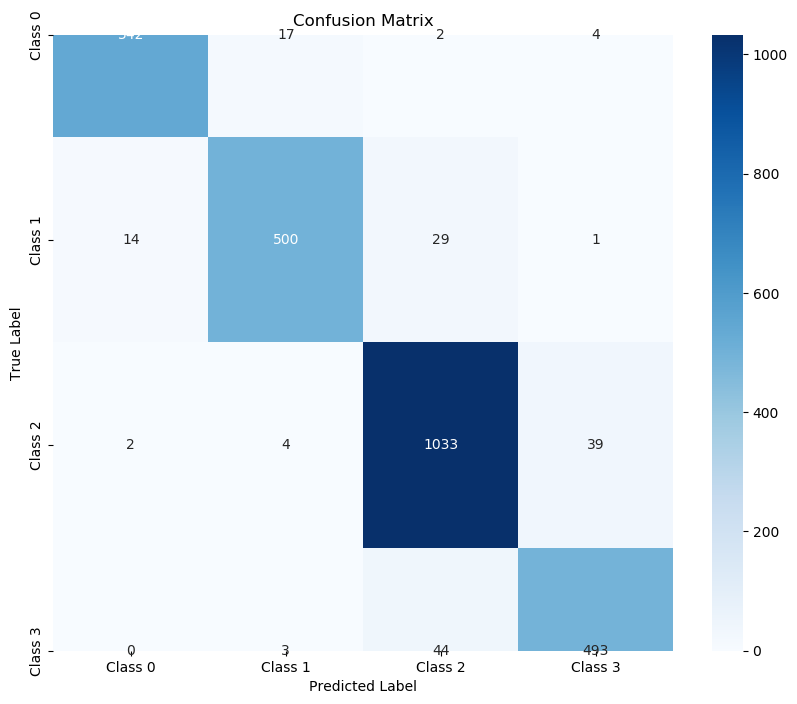

              precision    recall  f1-score   support

     Class 0       0.97      0.96      0.97       565
     Class 1       0.95      0.92      0.94       544
     Class 2       0.93      0.96      0.95      1078
     Class 3       0.92      0.91      0.92       540

    accuracy                           0.94      2727
   macro avg       0.94      0.94      0.94      2727
weighted avg       0.94      0.94      0.94      2727



In [40]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# 加载保存的最佳模型参数
model.load_state_dict(torch.load('best_model.pth'))

test_loader = val_loader

# 如果 CUDA（GPU）可用，则将模型移动到 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 确保模型处于评估模式
model.eval()

# 存储真实标签和预测标签
true_labels = []
predicted_labels = []

# 不计算梯度，因为我们不在训练模式
with torch.no_grad():
    for inputs, labels in test_loader:
        # 将数据移动到 GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # 前向传播，计算模型输出
        outputs = model(inputs)

        # 获取预测结果，即最大概率的标签
        _, preds = torch.max(outputs, 1)

        # 将预测结果和真实标签保存起来
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(preds.cpu().numpy())

# 计算混淆矩阵
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# 计算评价指标
classification_rep = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])

# 使用 seaborn 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [45]:
import pandas as pd

report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'], output_dict=True)

# 转换为 DataFrame
report_df = pd.DataFrame(report).transpose()

# 设置 seaborn 样式
sns.set_theme(style="whitegrid")

# 创建一个颜色条，使其与您想要的颜色匹配
cmap = sns.light_palette("blue", as_cmap=True)

# 在 DataFrame 上应用样式
styled_df = report_df.style.background_gradient(cmap=cmap)

# 在 Jupyter Notebook 中显示样式化的 DataFrame
styled_df

,precision,recall,f1-score,support
Class 0,0.971326,0.959292,0.965272,565.000000
Class 1,0.954198,0.919118,0.936330,544.000000
Class 2,0.932310,0.958256,0.945105,1078.000000
Class 3,0.918063,0.912963,0.915506,540.000000
accuracy,0.941694,0.941694,0.941694,0.941694
macro avg,0.943975,0.937407,0.940553,2727.000000
weighted avg,0.941939,0.941694,0.941672,2727.000000
